In [1]:
import os
import pdb
from pathlib import Path
from glob import glob
import re
import sys
sys.path.append('../') # using sys to import from parent directory

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import h5py
import nibabel as nib

from aiden_utils import load_mat, KCrop, crop_cmrx
from utils.mymath import ifft2c, fft2c
from cascadenet_pytorch.dnn_io import from_tensor_format

In [2]:
%load_ext autoreload
%autoreload 2

# Function Library

In [3]:
# load mat file from MRI dataset, return a numpy ndarray (complex)
# def load_mat(file_path:str):
#     with h5py.File(file_path, 'r') as f:
#         key0 = list(f.keys())[0]
#         assert len(list(f.keys())) == 1, "There is more than 1 key in the mat file."
#         # print(f.keys())
#         # print(f['kspace_single_sub04']) # shape (9, 5, 10, 144, 512)
#         try:
#             dataset = f[key0][:]
#         except KeyError:
#             print(f'Key Error, options:{f.keys()}')
    
#     # dataset_complex = convert_from_void_to_complex(dataset)
#     return dataset


def to_complex(data: np.ndarray) -> np.ndarray:
    return data['real'] + 1j * data['imag']

# def prep_data():
#     acc_factor_04_path = '../data/SingleCoil/AccFactor04/'
#     patient = 'P001'
    
#     T1_map = load_mat(os.path.join(acc_factor_04_path, patient, 'T1_map.mat'))
#     T1_map_mask = load_mat(os.path.join(acc_factor_04_path, patient, 'T1_map_mask.mat'))

def normalized(complex_data_im, t_mean=8.762e-05, t_std=1.559e-04):
    phase = np.angle(complex_data_im)
    magnitude = np.abs(complex_data_im)
    normalized_magnitude = (magnitude - t_mean) / t_std
    im = normalized_magnitude * np.exp(1j * phase)
    k = fft2c(im)
    return im, k

def show_statistics(demo):
    demo_real = demo.real
    demo_imag = demo.imag
    demo_abs = np.abs(demo)
    print('real mean, std:', np.mean(demo_real), np.std(demo_real))
    print('real max, min:', np.max(demo_real), np.min(demo_real))
    print('imag mean, std:', np.mean(demo_imag), np.std(demo_imag))
    print('imag max, min:', np.max(demo_imag), np.min(demo_imag))
    print('abs mean, std:', np.mean(demo_abs), np.std(demo_abs))
    print('abs max, min:', np.max(demo_abs), np.min(demo_abs))
    
def crop_cmrx(im):
    # if 4 dim:
    if len(im.shape) == 4:
        _, _, kx, ky = im.shape
        im_crop = im[:,:,kx//3:2*kx//3, ky//4:3*ky//4]
    elif len(im.shape) == 2:
        kx, ky = im.shape
        im_crop = im[kx//3:2*kx//3, ky//4:3*ky//4]
    return im_crop

def inspect_tensor_numpy(data_path=None):
    t_im = np.load(data_path)
    t_im_demo = t_im[0,0,:,:,0] + t_im[0,1,:,:,0] * 1j
    return t_im_demo

def npy_to_ax(ax, path, is_save=False, s=0, t=0):
    pred_n_now = np.load(path)
    
    if pred_n_now.ndim == 5:
        pred_n_now = from_tensor_format(pred_n_now)
    print(pred_n_now.shape)
    ax.imshow(np.abs(pred_n_now[s,t,...]), cmap='gray')
    
    if is_save:
        return np.abs(pred_n_now[s,t,...])
    
def loadernpy_to_ax(ax, path):
    data= np.load(path)
    assert data.shape[0] == 2
    data_complex = data[0,...] + 1j * data[1,...]
    # 171 72 9 
    data_complex = np.transpose(data_complex, (2,0,1))
    ax.imshow(np.abs(data_complex[0,...]), cmap='gray')

# Check Original Preprocessing Method
- for CV project, preprocessing, 0,1 or min-max or z-score is necessary which influence the network performance.

In [2]:
dir_path = '../data/'
data_name = 'cardiac.mat'
cardiac  = sio.loadmat(os.path.join(dir_path,data_name))
# cardiac  = sio.loadmat(os.path.join(dir_path,data_name))
cardiac['seq'].shape # #@dim(256,256,30) simply a MRI model
cardiac_original_input = cardiac['seq']
cardiac_original_input_demo = cardiac_original_input[:,:,5]
print(type(cardiac_original_input_demo))

In [12]:
show_statistics(cardiac_original_input_demo)
fig,ax =plt.subplots()
ax.imshow(np.abs(cardiac_original_input_demo), cmap='gray')

real mean, std: 0.036393143 0.11296181
real max, min: 0.5432024 -0.45736688
imag mean, std: -0.009834921 0.1219812
imag max, min: 0.65226316 -0.48166198
abs mean, std: 0.11232796 0.12823182
abs max, min: 0.6764961 0.0


(144, 512)


0.0

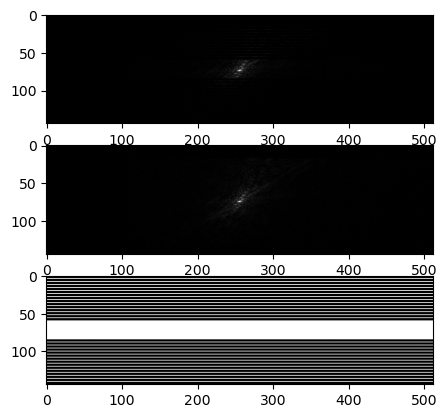

In [6]:
DATA_DIR = Path('../../data/SingleCoil/AccFactor04/P001/T1map.mat')
GT_DIR = Path('../../data/SingleCoil/FullSample/P001/T1map.mat')
MASK_DIR = Path('../../data/SingleCoil/AccFactor04/P001/T1map_mask.mat')

k_x = load_mat(DATA_DIR, complex=True) # 5,9,171,72
k_y = load_mat(GT_DIR, complex=True)
mask = load_mat(MASK_DIR, complex=False)
print(mask.shape)

fig, ax = plt.subplots(3,1)
ax[0].imshow(np.abs(k_x[0,0,:,:]), cmap='gray')
ax[1].imshow(np.abs(k_y[0,0,:,:]), cmap='gray')
ax[2].imshow((k_x[0,0,:,:] == k_y[0,0,:,:]).astype(int), cmap='gray')


def calculate_mse(y_true, y_pred):
    return np.mean(np.square(np.abs(y_true - y_pred)))

calculate_mse(k_x[0,0,:,:], k_y[0,0,:,:]*mask)

(144, 512)


619.9822136655371

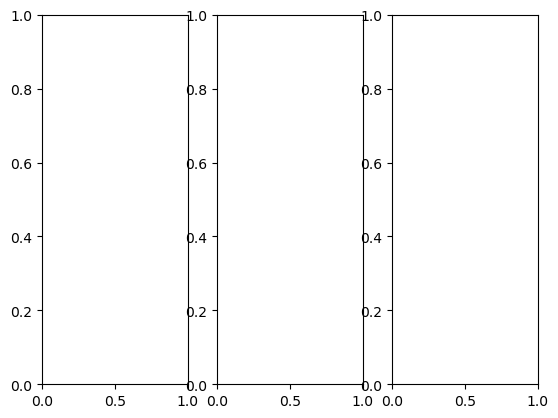

In [7]:
# ori (False) one
normalize = KCrop()
im_x_n, k_x_n = normalize(k_x[0,0])
im_y_n, k_y_n = normalize(k_y[0,0])

fig, ax = plt.subplots(1,3)

mask_n = normalize(mask, is_mask=True)
print(mask.shape)
# calculate the mse

calculate_mse(k_x_n, k_y_n*mask_n)

In [20]:
s = 5
t = 9
min_x_list = []
max_x_list = []
min_y_list = []
max_y_list = []

def get_min_max(k_space, i, j):
    curr_k_x = k_space[i,j,...]
    curr_im_x = ifft2c(curr_k_x)
    curr_im_x_crop = crop_cmrx(curr_im_x)
    abs_im_x_crop = np.abs(curr_im_x_crop)
    return abs_im_x_crop.min(), abs_im_x_crop.max()

for p_id in range(1,10):
    DATA_DIR = Path(f'../../data/SingleCoil/AccFactor04/P00{str(p_id)}/T1map.mat')
    GT_DIR = Path(f'../../data/SingleCoil/FullSample/P00{str(p_id)}/T1map.mat')

    k_x = load_mat(DATA_DIR, complex=True) # 5,9,171,72
    k_y = load_mat(GT_DIR, complex=True)

    for i in range(t):
        for j in range(s):
            curr_x_min, curr_x_max = get_min_max(k_x, i, j)
            curr_y_min, curr_y_max = get_min_max(k_y, i, j)
            min_x_list.append(curr_x_min)
            min_y_list.append(curr_y_min)
            max_x_list.append(curr_x_max)
            max_y_list.append(curr_y_max)
        
min_x_list = np.array(min_x_list)
max_x_list = np.array(max_x_list)
min_y_list = np.array(min_y_list)
max_y_list = np.array(max_y_list)

print(min_x_list.min(), min_x_list.max(), min_x_list.mean(), min_x_list.std())
print(min_y_list.min(), min_y_list.max(), min_y_list.mean(), min_y_list.std())
print(max_x_list.min(), max_x_list.max(), max_x_list.mean(), max_x_list.std()) 
print(max_y_list.min(), max_y_list.max(), max_y_list.mean(), max_y_list.std())
     

1.3003162394226257e-08 2.1742912654923337e-06 3.856117090963932e-07 3.270735484192601e-07
4.581107044994947e-06 1.1862433804378146e-05 7.889105133858725e-06 1.0092906912431669e-06
0.00029415163699493877 0.0022530686047832057 0.0010866219549167761 0.000474322613934912
0.0003597659705637745 0.003146305299044842 0.001425476034033016 0.0006548376235957062


In [18]:
P001
7.531031242944898e-08 1.998519895102121e-06 4.841892591115683e-07 3.5594074720103825e-07
5.075063940337701e-06 9.850817432951013e-06 7.795577254871371e-06 9.988941097566782e-07
0.00034625183944359005 0.0018430792469650878 0.0009271534120220751 0.000440060770303226
0.00036409939525347995 0.002355011608688274 0.001176947303253358 0.0006162098728520077


P001 - P009
1.3003162394226257e-08 2.1742912654923337e-06 3.856117090963932e-07 3.270735484192601e-07
4.581107044994947e-06 1.1862433804378146e-05 7.889105133858725e-06 1.0092906912431669e-06
0.00029415163699493877 0.0022530686047832057 0.0010866219549167761 0.000474322613934912
0.0003597659705637745 0.003146305299044842 0.001425476034033016 0.0006548376235957062

0.0030239999999999998

# Intermediate variables inspection


`np.save('_inspect/0727_res_dcs_1', from_tensor_format(x_res.detach().cpu().numpy()))`

Now has been integrated to `npy_to_ax`

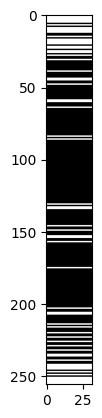

In [3]:
dummy_mask = np.load('dummy_mask.npy')
fig,ax = plt.subplots()
ax.imshow(dummy_mask, cmap='gray')

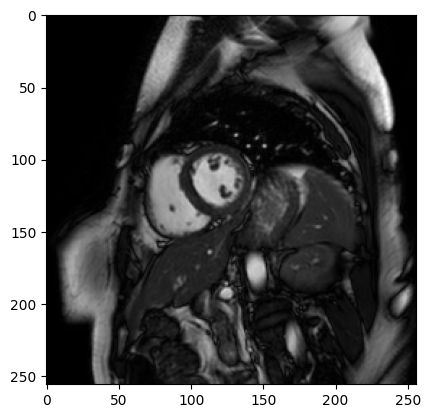

In [10]:
data = np.load('data.npy')
idx = 5
data_0 = data[idx]

# show the magnitude of the first image
fig,ax = plt.subplots()
ax.imshow(np.abs(data_0), cmap='gray')

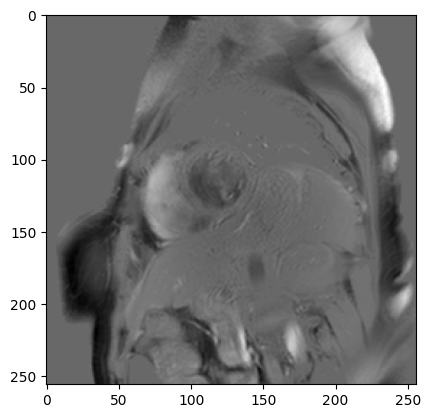

In [20]:
# display imag part of the first image
fig, ax = plt.subplots()
ax.imshow(data[0].imag, cmap='gray')

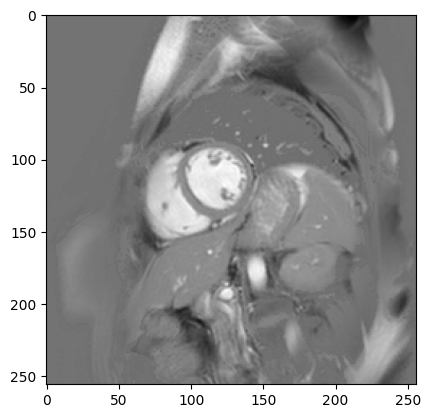

In [19]:
fig, ax = plt.subplots()
ax.imshow(data[0].real,cmap='gray')

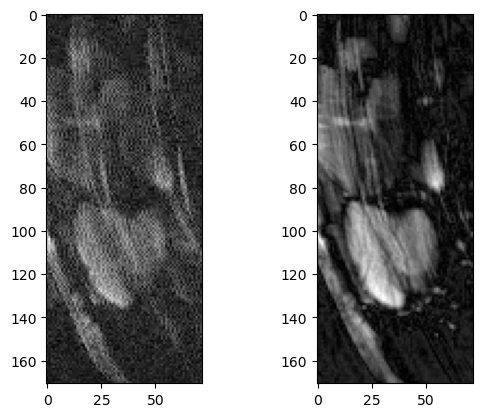

In [26]:
t_im_demo = crop_cmrx(inspect_tensor_numpy('t_im_npy.npy'))

pred_full = inspect_tensor_numpy('pred.npy')
pred_crop = crop_cmrx(pred_full)

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(pred_crop), cmap='gray')
ax[1].imshow(np.abs(t_im_demo), cmap='gray')

# remove artefacts

(5, 1, 171, 72)


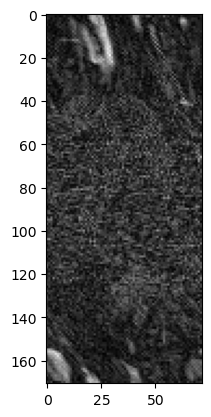

In [17]:
pred_n_now = np.load('pred_0726_tarin_2.npy')
print(pred_n_now.shape)
fig,ax = plt.subplots()
ax.imshow(np.abs(pred_n_now[0,0,...]), cmap='gray')

(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)


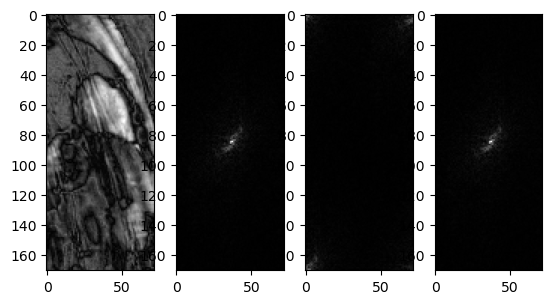

In [7]:
# check dcs layer
pred_n_now = np.load('x.npy')
print(pred_n_now.shape)
fig,ax = plt.subplots(1,4)
ax[0].imshow(np.abs(pred_n_now[0,0,...]), cmap='gray')
ax[1].imshow(np.abs(fft2c(pred_n_now[0,0,...])), cmap='gray')
npy_to_ax(ax[2], '0726_dcs_k.npy')
npy_to_ax(ax[3], '0726_dcs_k_2.npy')

(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)


Text(0.5, 1.0, 'ifft2c of ku_1 in input data')

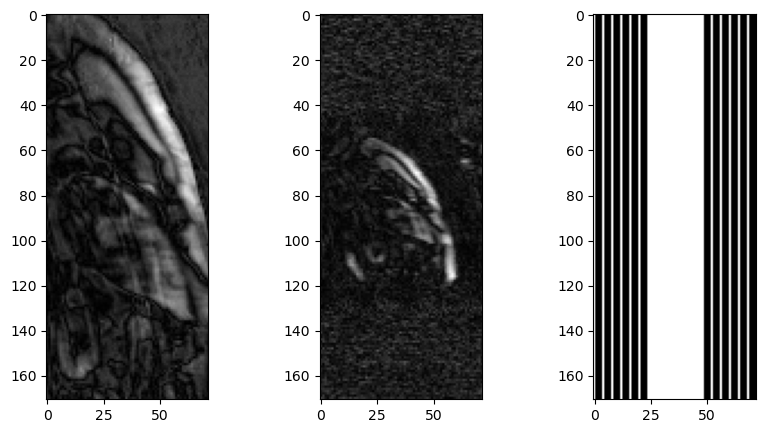

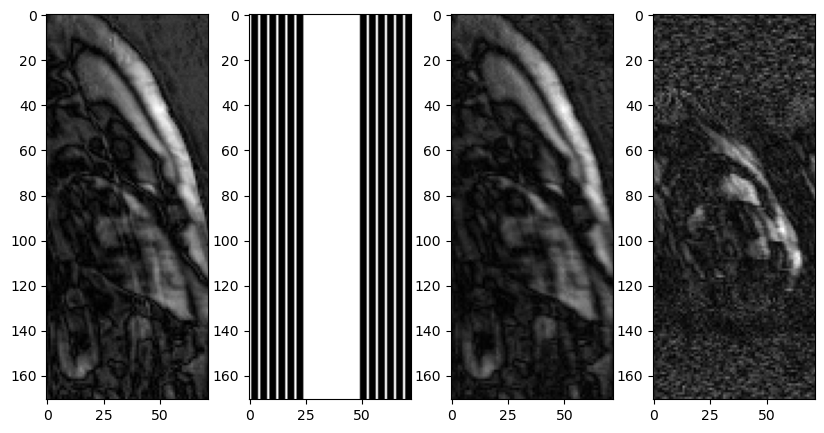

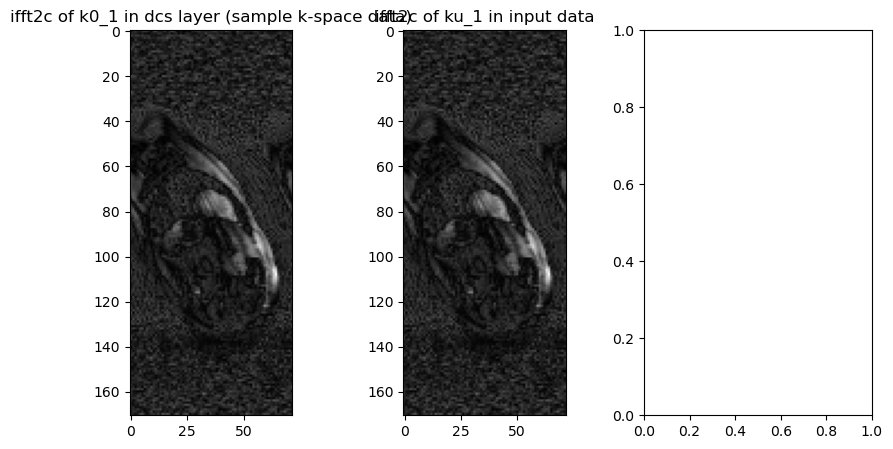

In [5]:
# after modifying the dcs layer

# check dcs layer
fig, ax = plt.subplots(1,3, figsize=(10,5))
npy_to_ax(ax[0], '0726_imu_1.npy')
npy_to_ax(ax[1], '0726_rec_1.npy')
npy_to_ax(ax[2], '0726_mask_1.npy')

# check if the mask is applied to k-space of imu directly
masks = np.load('0726_mask_1.npy')
mask_1 = masks[0,0,...].real
# print(mask_1)


imus = np.load('0726_imu_1.npy')
imu_1 = imus[0,0,...]
print(imus.shape)

k_1 = fft2c(imu_1)
# apply mask on k_1
k_1 = k_1 * mask_1
imu1_dcs = ifft2c(k_1)

fig, ax = plt.subplots(1,4, figsize=(10,5))
ax[0].imshow(np.abs(imu_1), cmap='gray')
ax[1].imshow(mask_1, cmap='gray')
ax[2].imshow(np.abs(imu1_dcs), cmap='gray')
npy_to_ax(ax[3], '0727_res_dcs_1.npy')

# show the dcs change relationship map

fig, ax = plt.subplots(1,3, figsize=(10,5))

k0_1 = np.load('0727_k0_1.npy')
k0_1_complex = k0_1[..., 0] + 1j * k0_1[..., 1]
ax[0].imshow(np.abs(ifft2c(k0_1_complex[0,0,...])), cmap='gray')
ax[0].set_title('ifft2c of k0_1 in dcs layer (sample k-space data)')

ku_1 = np.load('0727_ku_1.npy')
ku_1_complex = ku_1[:,0,...] + 1j * ku_1[:,1,...]
ku_1_complex = np.transpose(ku_1_complex, (0,3,1,2))
ax[1].imshow(np.abs(ifft2c(ku_1_complex[0,0,...])), cmap='gray')
ax[1].set_title('ifft2c of ku_1 in input data')


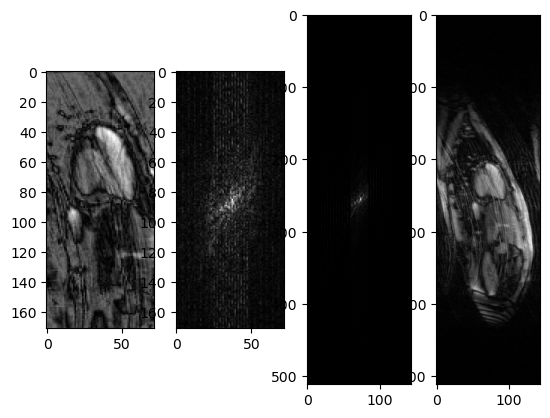

In [7]:
fig ,ax = plt.subplots(1,4)

loadernpy_to_ax(ax[0], '0727_loader_imx_1.npy')
loadernpy_to_ax(ax[1], '0727_loader_kx_1.npy')

ori_x = np.load('0727_loader_x_1.npy')
ori_x = np.transpose(ori_x, (0,2,1))
ax[2].imshow(np.abs(ori_x[0, ...]), cmap='gray')

imxc_1 = np.load('0727_loader_imxc_1.npy')
ax[3].imshow(np.abs(imxc_1[0, ...]), cmap='gray')


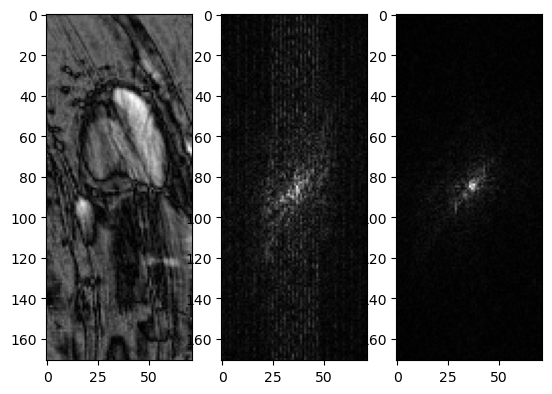

In [9]:
# check status has been updated to data loader
im_crop_1 = np.load('0727_loader_imcrop_1.npy')
k_crop_1 = np.load('0727_loader_kcrop_1.npy')
k_crop_ifft_1 = np.load('0727_loader_kcrop_fftim_1.npy')

fig ,ax = plt.subplots(1,3)
ax[0].imshow(np.abs(im_crop_1[0,...]),cmap='gray')
ax[1].imshow(np.abs(k_crop_1[0,...]),cmap='gray')
ax[2].imshow(np.abs(k_crop_ifft_1[0,...]),cmap='gray')

In [5]:
def normalize_test(im, norm='z'):
    # im_mean = np.mean(im, axis=0)
    # im_std = np.std(im, axis=0)
    # print(im_mean.shape)
    # im_norm = (im - im_mean) / im_std
    # return im_norm
    
    assert norm in ['z','m'], 'norm must be z (stands for z-score) or m (stands for min-max)'
    
    im_angle = np.angle(im)
    im_abs = np.abs(im)
    
    if norm == 'z':
        im_abs_normed = (im_abs - np.mean(im_abs)) / np.std(im_abs)
    elif norm == 'm':
        abs_min, abs_max = np.min(im_abs), np.max(im_abs)
        im_abs_normed = (im_abs - abs_min) / (abs_max - abs_min)
        
    im_abs_normed = im_abs_normed * np.exp(1j * im_angle) 
    
    return im_abs_normed

real mean, std: 7.959093632730801e-07 0.00012124182160179249
real max, min: 0.0010319421257631754 -0.0014122477504116095
imag mean, std: 2.224868182044516e-06 8.481072119677584e-05
imag max, min: 0.0008998757620110307 -0.001055607643242328
abs mean, std: 7.283602866860927e-05 0.00012881356362264674
abs max, min: 0.0015352317045893042 8.046569098133334e-09
real mean, std: 0.0005184202086719526 0.078971540390473
real max, min: 0.6721719127768209 -0.9198921978455323
imag mean, std: 0.0014491450621221106 0.055241384477987446
imag max, min: 0.5861484024371896 -0.6875871642769877
abs mean, std: 0.04743802749459232 0.08390540554121095
abs max, min: 0.9999999999999999 0.0


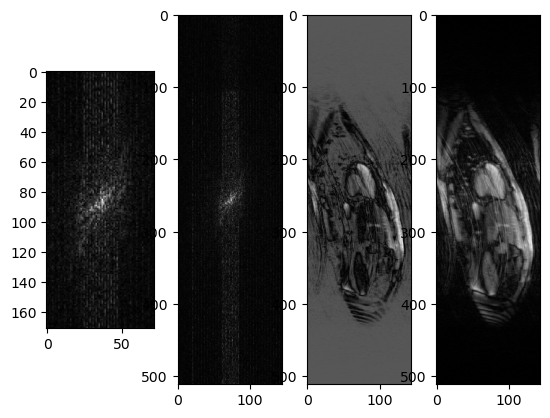

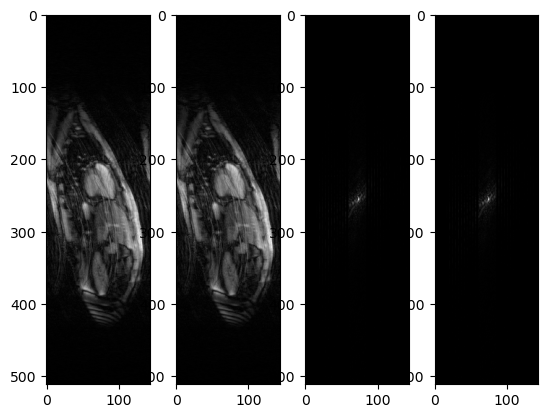

In [6]:
false_kcrop_1 = np.load('0728_loader_false_kcrop_1.npy')
k_1 = np.load('0728_loader_k_1.npy')
normalized_im_1 = np.load('0728_loader_normalized_im_1.npy')
ori_im_1 = np.load('0728_loader_im_1.npy')

fig ,ax = plt.subplots(1,4)
ax[0].imshow(np.abs(false_kcrop_1[0,...]),cmap='gray')
ax[1].imshow(np.abs(k_1[0,...]),cmap='gray')
# ax[2].imshow(np.abs(k_crop_ifft_1[0,...]),cmap='gray')
ax[2].imshow(np.abs(normalized_im_1[0,...]),cmap='gray')
ax[3].imshow(np.abs(ori_im_1[0,...]),cmap='gray')

show_statistics(ori_im_1)

im_2 = normalize_test(ori_im_1, norm='m')
fig, ax = plt.subplots(1,4)
ax[0].imshow(np.abs(im_2[0]), cmap='gray')
ax[1].imshow(np.abs(ori_im_1[0]), cmap='gray')

fft_im_2 = fft2c(im_2[0])
fft_ori_im_1 = fft2c(ori_im_1[0])
ax[2].imshow(np.abs(fft_im_2), cmap='gray')
ax[3].imshow(np.abs(fft_ori_im_1), cmap='gray')

show_statistics(im_2)

In [ ]:
# normalization methods used by the junoir
def norm_im(x):
    # x = ifft2c(x)
    x = x / np.max(x)
    x = fft2c(x)
    return np.max(x), x

(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)
(1, 9, 171, 72)


Text(0.5, 0.98, '10th epochs')

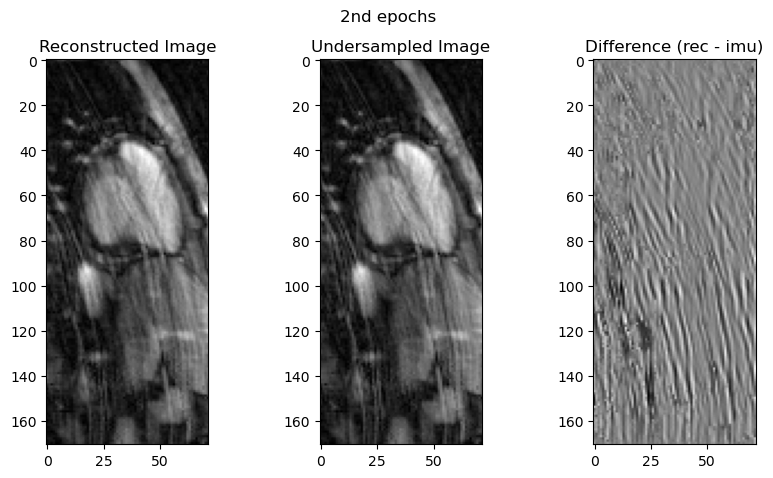

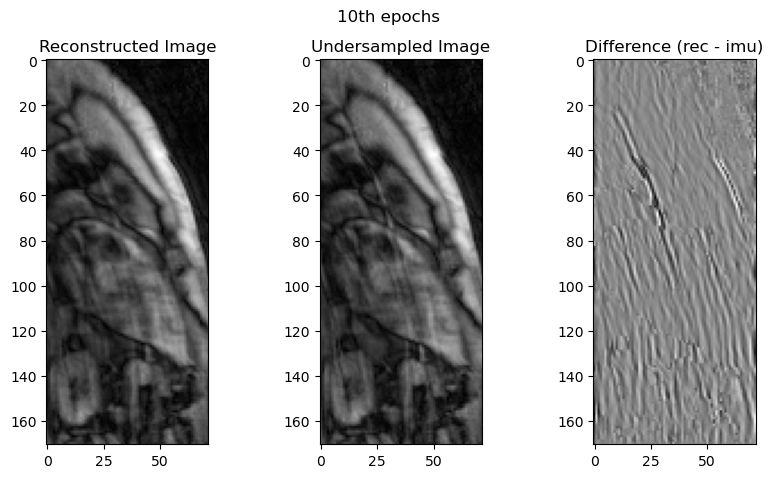

In [14]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
rec = npy_to_ax(ax[0], '0729_rec_1.npy', is_save=True)
ax[0].set_title('Reconstructed Image')
imu = npy_to_ax(ax[1], '0729_imu_1.npy', is_save=True)
ax[1].set_title('Undersampled Image')
ax[2].imshow(rec-imu, cmap='gray')
ax[2].set_title('Difference (rec - imu)')
fig.suptitle('2nd epochs')


fig, ax = plt.subplots(1,3,figsize=(10,5))
rec = npy_to_ax(ax[0], '0729_rec_2.npy', is_save=True)
ax[0].set_title('Reconstructed Image')
imu = npy_to_ax(ax[1], '0729_imu_2.npy', is_save=True)
ax[1].set_title('Undersampled Image')
ax[2].imshow(rec-imu, cmap='gray')
ax[2].set_title('Difference (rec - imu)')
fig.suptitle('10th epochs')


(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)


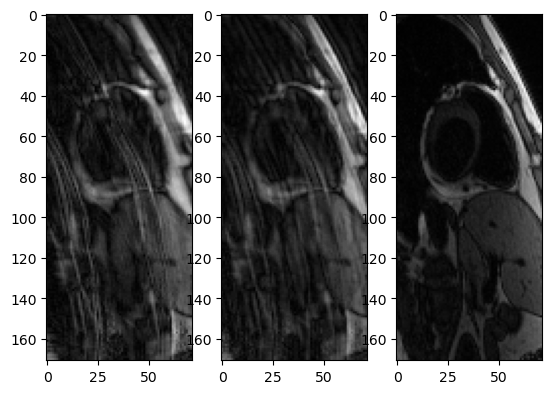

In [6]:
fig, ax = plt.subplots(1,3)
s,t = 0,5
npy_to_ax(ax[0], '0802_imu_1.npy',s=s,t=t)
npy_to_ax(ax[1], '0802_pred_1.npy',s=s,t=t)
npy_to_ax(ax[2], '0802_img_1.npy',s=s,t=t)

(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)


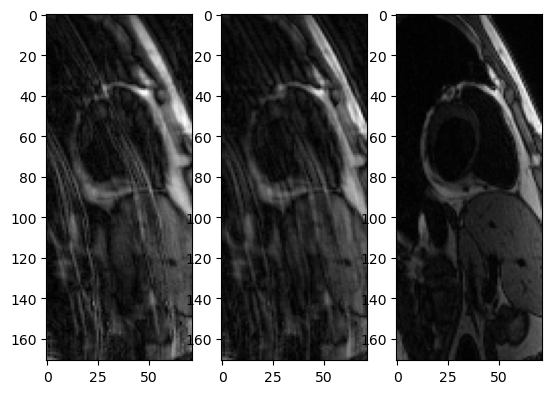

In [5]:
fig, ax = plt.subplots(1,3)
s,t = 0,4
npy_to_ax(ax[0], '0802_imu_1.npy',s=s,t=t)
npy_to_ax(ax[1], '0802_pred_2.npy',s=s,t=t)
npy_to_ax(ax[2], '0802_img_1.npy',s=s,t=t)

(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)


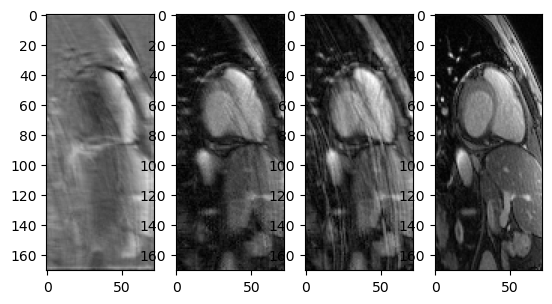

In [4]:
fig, ax = plt.subplots(1,4)
s,t = 0,0
npy_to_ax(ax[0], '0808_pred_dcl_1.npy',s=s,t=t)
npy_to_ax(ax[1], '0808_pred_nodcl_1.npy',s=s,t=t)
npy_to_ax(ax[2], '0808_imu_1.npy',s=s,t=t)
npy_to_ax(ax[3], '0808_img_1.npy',s=s,t=t)

(5, 9, 171, 72)
(5, 9, 171, 72)
3.110603609553053e-17


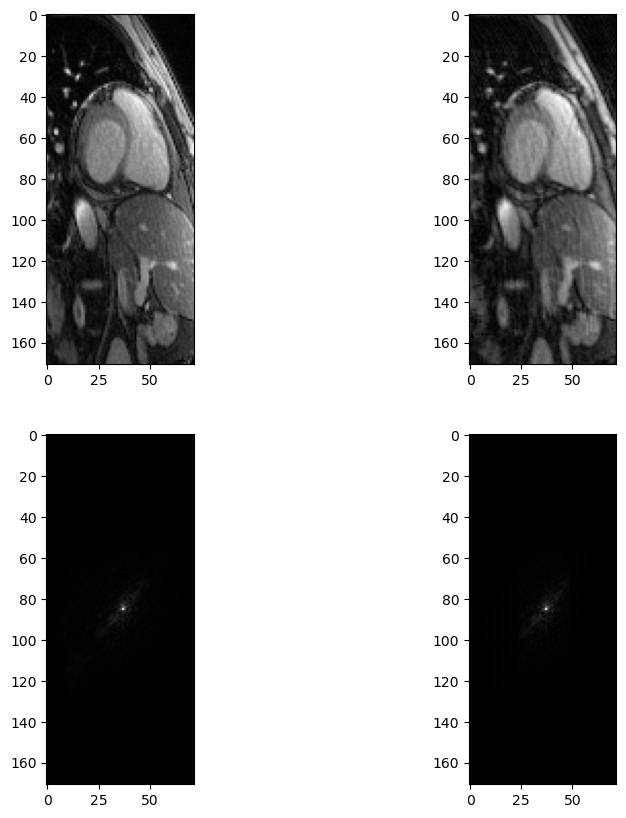

In [10]:
# provided parameter: mask_1
img_1 = np.load('0808_img_1.npy')
imu_1 = np.load('0808_imu_1.npy')
print(img_1.shape)
print(imu_1.shape)

img1_sample = img_1[0,0]
img_gt = img1_sample # image space
k_gt = fft2c(img_gt) # k-space

# downsample k-space
k_u = k_gt * mask_1
img_u = ifft2c(k_u)

fig,ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(np.abs(img_gt),cmap='gray')
ax[0,1].imshow(np.abs(img_u),cmap='gray')
ax[1,0].imshow(np.abs(k_gt),cmap='gray')
ax[1,1].imshow(np.abs(k_u),cmap='gray')

# as img_u as input
k_input = fft2c(img_u)

# calculate the mse between k_input and k_gt*mask_1:
rmse = np.sqrt(np.mean(np.square(np.abs(k_input - k_gt*mask_1))))
print(rmse)

# Loss

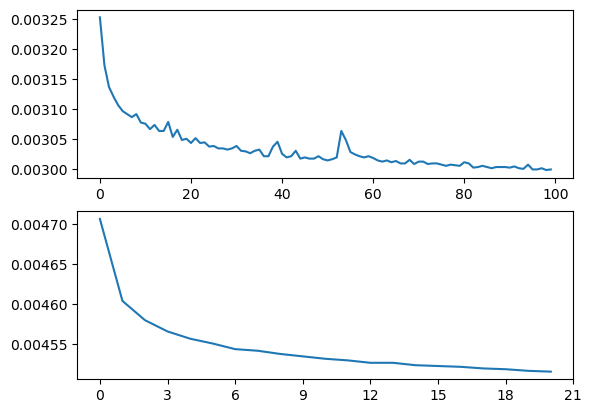

In [11]:
from matplotlib.ticker import MaxNLocator
with open('../pbs_log/8034222.pbs.OU','r+') as f:
    context = f.read() # readlines, read
    losses = re.findall(r'training loss:\s+([\d\.]+)', context)
    loss_100e_list = [float(loss) for loss in losses]
    
with open('../pbs_log/8034227.pbs.OU','r+') as f:
    context = f.read() # readlines, read
    losses = re.findall(r'training loss:\s+([\d\.]+)', context)
    loss_20e_list = [float(loss) for loss in losses]
    


fig, ax = plt.subplots(2,1)
ax[0].plot(loss_100e_list)
ax[1].plot(loss_20e_list)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)
(5, 9, 171, 72)


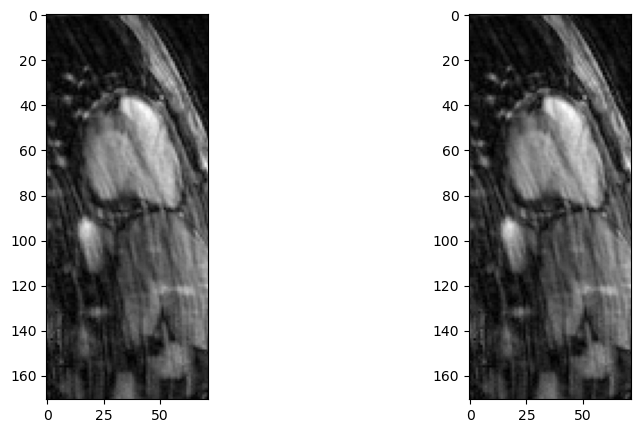

In [14]:
# Further verify the T1 mapping 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
s, t= 0,0
pred_P001 = np.load('0802_pred_P001.npy') # P002
print(pred_P001.shape)

pred_P002 = np.load('0802_pred_P002.npy') # P002
print(pred_P002.shape)
npy_to_ax(ax[0],'0802_pred_P001.npy',s=s,t=t )
npy_to_ax(ax[1],'0802_pred_P002.npy',s=s,t=t)

# P001 pred values

In [19]:
# verify the T1 mapping parameters
DATA_DIR = Path('../../data/SingleCoil/SegmentROI/')
nii_data = nib.load(DATA_DIR/'P001'/'T1map_forlabel.nii.gz')

# Get the data as a numpy array
t1_P001 = nii_data.get_fdata()
print(t1_P001.shape)

t1_P001 = np.array(t1_P001)
t1_P001 = t1_P001.transpose(2, 0, 1)

kx, ky = t1_P001.shape[-1:]

t1_P001_crop = t1_P001[..., kx//3: 2*kx//3, ky//4:3*ky//4]


(512, 144, 5)


# Check dataload

(9, 5, 144, 512)
(144, 512)


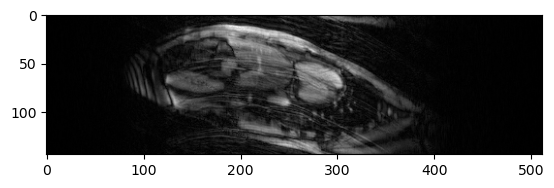

In [15]:
acc_factor_04_path = '../../data/SingleCoil/AccFactor04/'
patient = 'P001'
# os.path.join(acc_factor_04_path, patient, 'T1map.mat')
T1_map = load_mat(os.path.join(acc_factor_04_path, patient, 'T1map.mat'))
T1_map_complex = to_complex(T1_map)
print(T1_map_complex.shape)
k = T1_map_complex[0,0]
print(k.shape)
im = fft2c(k)
fig,ax = plt.subplots()
ax.imshow(np.abs(im), cmap='gray')

(9, 5, 144, 512)
(144, 512)


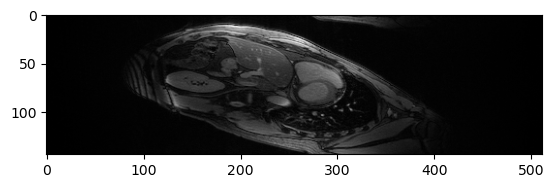

In [20]:
ground_truth_path = '../../data/SingleCoil/FullSample'
patient = 'P001'
# os.path.join(acc_factor_04_path, patient, 'T1map.mat')
T1_map = load_mat(os.path.join(ground_truth_path, patient, 'T1map.mat'))
T1_map_complex = to_complex(T1_map)
print(T1_map_complex.shape)
k = T1_map_complex[0,0] # only 0, 1, 2
print(k.shape)
im = fft2c(k)
fig,ax = plt.subplots()
ax.imshow(np.abs(im), cmap='gray')

im stats:
real mean, std: -1.3378737910737488e-07 0.00011041700098799725
real max, min: 0.0008725226628026634 -0.0008447431373365762
imag mean, std: -2.163322353012502e-06 9.514117047524639e-05
imag max, min: 0.0008978866003987965 -0.000734280027363893
abs mean, std: 8.132567654563882e-05 0.00012097350380824418
abs max, min: 0.001005536148623285 2.8916143242283227e-06
im_crop stats:
real mean, std: -1.448206867910933e-07 0.00014365807384004761
real max, min: 0.0008725226628026634 -0.0008447431373365762
imag mean, std: -3.7546560089707602e-06 0.0001238960390662302
imag max, min: 0.0008978866003987965 -0.000734280027363893
abs mean, std: 0.00012965616932394513 0.00013853254796888313
abs max, min: 0.001005536148623285 7.870017769108207e-06


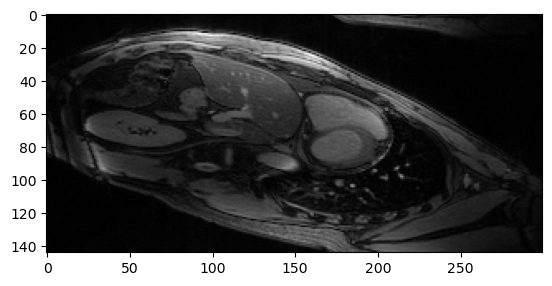

In [21]:
print('im stats:')
show_statistics(im)
im_crop = im[:,100:400]
fig,ax = plt.subplots()
ax.imshow(np.abs(im_crop), cmap='gray')
print('im_crop stats:')
show_statistics(im_crop)

real mean, std: 0.0 0.9999999999999999
real max, min: 6.322557349454642 -0.8791157987088511
imag mean, std: 0.0 0.0
imag max, min: 0.0 0.0
abs mean, std: 0.7750488281331055 0.6319013483206853
abs max, min: 6.322557349454642 5.7597393227780034e-05
real mean, std: 0.11232796000000002 0.12823182
real max, min: 0.9230809959749448 -0.0004026588591896224
imag mean, std: 0.0 0.0
imag max, min: 0.0 0.0
abs mean, std: 0.11232799105692101 0.1282317927948848
abs max, min: 0.9230809959749448 5.365240784566128e-07
(144, 300)
transformed_stats:
real mean, std: -0.010877012451461866 0.7435447552921657
real max, min: 5.459305927280784 -5.173361186169239
imag mean, std: -0.04525312584058958 0.66706449619156
imag max, min: 5.545493023734153 -4.48403413826359
abs mean, std: 0.7750488281331053 0.6319013483206853
abs max, min: 6.322557349454641 5.7597393227780034e-05


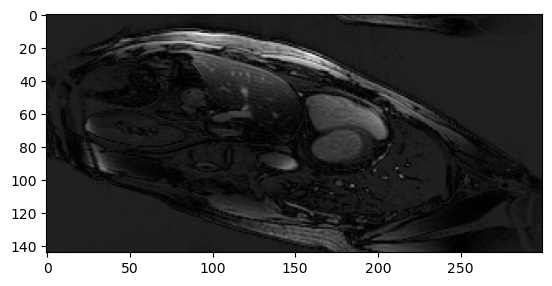

In [26]:
# normalize 
phase = np.angle(im_crop)
magnitude = np.abs(im_crop)

ori_mean = 0.11232796 
ori_std = 0.12823182
normalized_magnitude = (magnitude - np.mean(magnitude)) / np.std(magnitude)
show_statistics(normalized_magnitude)
transformed_magnitude = normalized_magnitude * ori_std + ori_mean
show_statistics(transformed_magnitude)

transformed_complex_image = normalized_magnitude * np.exp(1j * phase)

print(transformed_complex_image.shape)
print('transformed_stats:')
show_statistics(transformed_complex_image)

fig,ax = plt.subplots()
ax.imshow(np.abs(transformed_complex_image), cmap='gray')

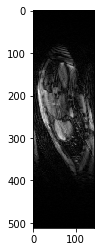

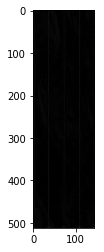

In [5]:
und_i = np.load('und_i.npy')
pred_i = np.load('pred_i.npy')

fig,ax = plt.subplots()
ax.imshow(np.abs(und_i), cmap='gray')

fig,ax = plt.subplots()
ax.imshow(np.abs(pred_i), cmap='gray')


In [16]:
def prep_data(patient = 'P001', norm=False):
    acc_factor_04_path = '../../data/SingleCoil/AccFactor04/'
    ground_truth_path = '../../data/SingleCoil/FullSample'
    patient = 'P001'
    
    k_und = to_complex(load_mat(os.path.join(acc_factor_04_path, patient, 'T1map.mat')))
    # change axis order to 0,1,2,3 -> 0,1,3,2
    k_und = np.transpose(k_und, (1,0,3,2)) 
    im_und = ifft2c(k_und)
        
    
    # mask
    mask = load_mat(os.path.join(acc_factor_04_path, patient, 'T1map_mask.mat')) # 144 * 512
    mask = mask.transpose(1,0) # 512 * 144
    # repeat and expand mask to match the shape of k_und
    b, t, _, _ = k_und.shape
    mask = np.tile(mask[np.newaxis, np.newaxis], (b, t, 1, 1))

    k_grd =  to_complex(load_mat(os.path.join(ground_truth_path, patient, 'T1map.mat')))
    k_grd = np.transpose(k_grd, (1,0,3,2)) # 5 (slice/batch)*9(kt)*512(kx)*144(ky)
    im_grd = ifft2c(k_grd)
    
    # whether use normalization 
    if norm:
        image_undersample, kspace_undersample = normalized(im_und)
        image_ground_truth, kspace_ground_truth = normalized(im_grd)
        return image_undersample, image_ground_truth, kspace_undersample, kspace_ground_truth, mask
    else:
        return im_und, im_grd, k_und, k_grd, mask

In [17]:
im_und, im_grd, k_und, k_grd, mask = prep_data(norm=False)

In [22]:
im_und.shape
crop_im_und = crop_cmrx(im_und)
print(crop_im_und.shape)
print("mean:{:.4e}, std:{:.4e}".format(np.mean(np.abs(crop_im_und)), np.std(np.abs(crop_im_und))))
# mean: 1.8283e-04
# std: 1.8676e-04

(5, 9, 171, 72)
mean:1.8283e-04, std:1.8676e-04


(171, 72)


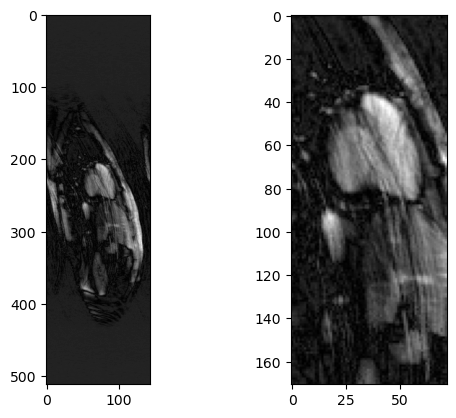

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(im_und[0,0,...]), cmap='gray')
crop_im_und = crop_cmrx(im_und[0,0,...])
ax[1].imshow(np.abs(crop_im_und), cmap='gray')

print(crop_im_und.shape)

# Check dataloader

- mask : all masks are the same

In [21]:
DATA_PATH = pathlib.Path('../../data/SingleCoil/')
DATA_PATH_04 = DATA_PATH / 'AccFactor04'
DATA_PATA_FULL = DATA_PATH / 'FullSample'

mask_list = []

for dir in DATA_PATH_04.iterdir():
    dir_name = dir.name # dir return the full path (without add DATA_PATH_04)
    if dir_name.startswith('.'):
        continue
    patient_T1map_mask = dir / 'T1map_mask.mat'
    # print(patient_T1map_mask)
    mask_list.append(load_mat(patient_T1map_mask))
    
# to compare items in mask_list is the same 
# print(all(np.array_equal(mask_list[0], arr) for arr in mask_list))

# Conclusion: all the mask is the same

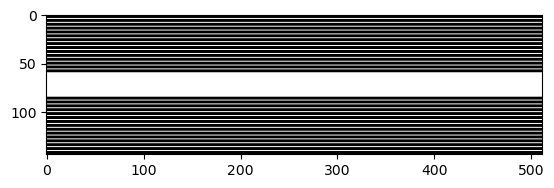

In [22]:
fig, ax = plt.subplots()
ax.imshow(mask_list[0], cmap='gray')

In [19]:
for dir in sorted(DATA_PATH_04.glob('P*')):
    print(dir)
    break

print(len((DATA_PATH_04.glob('P*'))))

../../data/SingleCoil/AccFactor04/P001


In [28]:
# check data shape in 04 and Full Sample
DATA_PATH = pathlib.Path('../../data/SingleCoil/')
DATA_PATH_04 = DATA_PATH / 'AccFactor04'
DATA_PATA_FULL = DATA_PATH / 'FullSample'

t1_map_shape_list = []

for dir in DATA_PATH_04.iterdir():
    dir_name = dir.name # dir return the full path (without add DATA_PATH_04)
    if dir_name.startswith('.'):
        continue
    patient_T1map = dir / 'T1map.mat'
    current_t1_map = to_complex(load_mat(patient_T1map))
    
    if len(current_t1_map.shape) == 5:
        print(dir)
    # pdb.set_trace()
    # print(patient_T1map_mask)
    t1_map_shape_list.append(current_t1_map.shape)
    
# to compare items in mask_list is the same 
print('shape in AccFactor04:')
print(set(t1_map_shape_list))


for dir in DATA_PATA_FULL.iterdir():
    dir_name = dir.name # dir return the full path (without add DATA_PATH_04)
    if dir_name.startswith('.'):
        continue
    patient_T1map = dir / 'T1map.mat'
    current_t1_map = to_complex(load_mat(patient_T1map))
    
    if len(current_t1_map.shape) == 5:
        print(dir)
    # pdb.set_trace()
    # print(patient_T1map_mask)
    t1_map_shape_list.append(current_t1_map.shape)
    
# to compare items in mask_list is the same 
print('shape in FullSample:')
print(set(t1_map_shape_list))


shape in AccFactor04:
{(9, 5, 144, 512), (9, 6, 144, 512), (9, 7, 144, 512)}
shape in FullSample:
{(9, 5, 144, 512), (9, 6, 144, 512), (9, 7, 144, 512)}


In [31]:
current_t1_map.shape[-2:]

(144, 512)